# Building your own maze-solving AI agent in Python

Reinforcement learning (RL) is a subfield of machine learning/AI in which an agent acts in an environment and learns to maximise the total reward it receives. RL has gained fame from video game AIs that have learned to play [Atari games](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning/), autonomous [helicopters that have learned to do some wild aerial manuevres](https://www.youtube.com/watch?v=VCdxqn0fcnE), and humanoid robots that have learned how to best [adjust limb positions and joint torques to stand up](https://gym.openai.com/envs/HumanoidStandup-v1) (sort of..) and even [walk and manoeuvre complex obstacle courses](https://www.youtube.com/watch?v=gn4nRCC9TwQ) (with only moderate crazy arm flailing). 

In this post, we want to make a reinforcement learning agent that can learn to escape a grid-like environment as quickly as possible. Although it's probably pretty trivial to code up solutions to solve mazes specifically, the point of using RL to solve the maze problem is that the technique is extremely generalisable - the Q learning approach explained here can be used to solve many diverse problems. So, although it might seem like we are using a very big hammer to smash quite a small fly, the idea is that once you understand RL in a small toy problem, you can begin to transfer the principles to more complex tasks. 

In our maze problem, there is a worm that needs to escape the maze as quickly as possible:

![Basic maze](https://raw.githubusercontent.com/jagex-data-science/maze_runner/master/basic_maze.png)

This is a pretty tame maze (nothing really on it - just +100 reward for getting to the end, and -1 everywhere else), so let's also make an advanced maze surrounded with dragon-filled lava (-100 reward, not good), a couple of perfectly-spherical trolls (-20 reward) and a treat (+20 reward, maybe a sugar cube... what do worms eat again?).

![Advanced maze](https://raw.githubusercontent.com/jagex-data-science/maze_runner/master/advanced_maze.png)

We'll use basic Python (+numpy/pandas) to allow the worm to learn how 'good' each state and action is - this goodness is represented by the values in the heatmap below. In this post, you'll see that the major trick is that these values incorporate information about potential future rewards leading on from that state. This means that once the agent knows these values (called Q values - we'll discuss), it can then make greedy decisions that maximise this value at each time step. This lets us solve simple grid worlds. We can then plot our trajectory within the grid world/maze, and the end result is a GIF sort of like this:  

![Traversal](https://raw.githubusercontent.com/jagex-data-science/maze_runner/master/traversal_in_10_steps_random_p0.0.gif)

If you just want the code to play around with, check out [this notebook](https://github.com/jagex-data-science/maze_runner/blob/master/maze_post_to_proofread.ipynb). The rest of the post will go through what the code is doing. In the next post, we'll make use of the code that is in place to do some experiments for seeing how changes to parameters (learning rate, exploration/exploitation trade-offs, number of episodes, episode length, on-policy/off-policy methods) affect our learned strategies. 

## The maze problem

First let's introduce some language for talking about RL problems, and then get into the code.

RL deals with sequential environments indexed by time points. We say that at any time point the worm can be in any number of ***states*** (the different squares on the grid) and can take various ***actions*** from each state (here, our action space is [left, right, up and down] - but in some spots, like corner states or next to obstacles, not all actions are available). Each state is associated with a ***reward*** $r$ - this is just a number, and is a property of the environment. So, we can make decisions about which action $a$ to take in a given state $s$ at time point $t$, and the environment gives a reward $r$ and puts us in a ***successor state*** $s'$. Each episode ends when the worm gets to ***terminal state*** - the end of the maze. Then, the worm is (cruelly) transported back to the beginning where it has to start again. Let's say there's no dying/respawning, so if you get into the lava you're punished severely (-100 reward) but you can still crawl out. 

### Rewards

Let's start setting up the environment. We need a reward matrix. For the simple maze, the numpy reward matrix looks like this:

In [8]:
# imports + a bit of setup first
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline
sns.set(font="monospace")
random.seed(42)

# basic maze state rewards
reward_matrix = np.array([[-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, 100]])

In the complicated maze, we've added a few other rewards, a lava moat, and a few obstacles (represented as rewards of 0). The numpy version is: 

In [10]:
# advanced maze state rewards
reward_matrix = np.array([[-1,   0, -1,  -1,  -1,  -1],
                          [-1, -20, -1,  20,  -1,  -1],
                          [-1,  -1, -1,  -1,  -1,  -1],
                          [-1,   0, -1,  -1, -20,  -1],
                          [-1,  -1, -1,   0,  -1,  -1],
                          [-1,  -1, -1,   0,  -1, 100]]).astype("float32")

reward_matrix = np.pad(reward_matrix, pad_width=1, mode='constant', constant_values=-100)
reward_matrix

array([[-100., -100., -100., -100., -100., -100., -100., -100.],
       [-100.,   -1.,    0.,   -1.,   -1.,   -1.,   -1., -100.],
       [-100.,   -1.,  -20.,   -1.,   20.,   -1.,   -1., -100.],
       [-100.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1., -100.],
       [-100.,   -1.,    0.,   -1.,   -1.,  -20.,   -1., -100.],
       [-100.,   -1.,   -1.,   -1.,    0.,   -1.,   -1., -100.],
       [-100.,   -1.,   -1.,   -1.,    0.,   -1.,  100., -100.],
       [-100., -100., -100., -100., -100., -100., -100., -100.]], dtype=float32)

Let's just stick to this more interesting matrix for now. 

The worm can go through the maze using four actions - up, down, left or right: 

In [11]:
actions = np.array(['up', 'down', 'left', 'right'])

And it's easy to see how these actions change your position in grid world.

In [12]:
def move(current_state, action):
    
    next_state_x, next_state_y = current_state
    
    if action=='up':
        next_state_x -=1
    elif action=='down':
        next_state_x +=1
    elif action=='left':
        next_state_y -=1
    elif action=='right':
        next_state_y +=1

    return [next_state_x, next_state_y]

For example, with numpy matrix indexing the upper left corner is [0, 0]. If we go right, this takes us to:

In [14]:
move([0,0], 'right')

[0, 1]

And if we're in the bottom right corner [7, 7] and we go up:

In [15]:
move([7,7], 'up')

[6, 7]

We can make a little function to get the possible actions based on current position - usually we can go any of the 4 directions, unless we're at the edge of the grid or next to an obstacle (obstacles are where the reward matrix has a value of 0, remember):

In [18]:
def get_possible_actions(current_state, possible_actions=actions, reward_matrix=reward_matrix):

    nrows, ncols = reward_matrix.shape
    x, y = current_state
    
    # checking first for grid corners
    # then for obstacles (where reward==0)
    if y==ncols-1 or reward_matrix[x, y+1]==0:
        possible_actions = np.setdiff1d(possible_actions, 'right')
    if y==0 or reward_matrix[x, y-1]==0:
        possible_actions = np.setdiff1d(possible_actions, 'left')
    if x==0 or reward_matrix[x-1, y]==0:
        possible_actions = np.setdiff1d(possible_actions, 'up')
    if x==nrows-1 or reward_matrix[x+1, y]==0:
        possible_actions = np.setdiff1d(possible_actions, 'down')
        
    return possible_actions

So, the possible actions in the lava corner [0,0] (take a look at the original grid) are:

In [19]:
get_possible_actions([0,0])

array(['down', 'right'], 
      dtype='|S5')

And the possible actions reflect the presence of obstacles, like in the position [4,3] where we can't go left:

In [20]:
get_possible_actions([4,3])

array(['down', 'right', 'up'], 
      dtype='|S5')

And sometimes we have both edge cases and obstacles to restrict our movement:

In [21]:
get_possible_actions([7,4])

array(['left', 'right'], 
      dtype='|S5')

Ok, so now we have figured out how the worm can move on the grid. The interesting part is learning how good it is for the worm to be in any state and take some action, so let's start diving into this. 

### Some of the maths behind the problem

This section isn't really crucial to the post so feel free to skip it, but I recently learned Latex so I've got an itch to type equations. 

As the worm goes through the maze, it will acquire a string of rewards. It will get some reward for time step $t$, $t+1$, $t+2$ and so on. The total reward in an episode (the **return $G_t$** from time point $t$ onwards) is just the sum:

\begin{align*}
    G_t = R_{t+1} + R_{t+2} + R_{t+3} \ ... \ + R_{n} = \sum_{t}^n R_{t+1}
\end{align*}

We want to encode some preference for immediate rewards, with future rewards being worth less because they are more uncertain and we generally have a preference towards recency. We can do this with **gamma discounting** - the parameter $\gamma$ controls our preference for immediate versus long-term rewards. 

\begin{align*}
    G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \gamma^3 R_{t+4} + \ ... \ = \sum_{k=0}^{\inf} \gamma^k R_{t+k+1}
\end{align*}

The gamma parameter can be any value between 0 and 1. At the extremes, if $\gamma$==0, then we are only interested in the most immediate rewards (all rewards after time $t$ are multiplied by 0 and disappear); if $\gamma$==1, then we are equally as interested in far away future rewards we are in the most immediate reward. So, this introduces a judgement where we prefer immediate reward (unless $\gamma$ is 1). If we set our discount factor to be $\gamma$=0.5, this would mean that we halve the amount we care about returns at each step. Notice that the very next reward $R_{t+1}$ isn't discounted by $\gamma$.

The **value of a state** $v(s)$ is actually defined as the expectation of the return when you start in that state: 

\begin{align*}
    v(s) = \mathbb{E}[G_t \ | \ S_t=s]
\end{align*}

So, how good a particular state is depends on how much reward you expect to get in the future leading on from the state. Let's substitute the definition of $G_t$ back in:

\begin{align*}
    v(s) =& \mathbb{E}[R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... \ | \ S_t = s]
\end{align*}
   
    
You might have noticed that the equation for the return $G_t$ has a bit of a recursive structure. It's made up of two parts - the immediate reward $R_{t+1}$ and the discounted rewards for $t+2$ onwards (i.e. $\gamma R_{t+2} + \gamma ^2 R_{t+3} + ... $). But, this second part is just the $\gamma$ times the rewards for the next time step onwards!

\begin{align*}
    v(s) =& \ \mathbb{E} [G_t \ | \ S_t = s] \\
         =& \  \mathbb{E} [R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... \ | \ S_t = s] \\
         =& \ \mathbb{E} [R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + ... ) \ | \ S_t = s] \\
         =& \ \mathbb{E} [R_{t+1} + \gamma (G_{t+1}) \ | \ S_t = s] 
\end{align*}

In the expanded definition of $G_t$, if we factorise out the $\gamma$ discounting factor, you can see that $\gamma (R_{t+2} + \gamma R_{t+3} + ... $ is simply $\gamma$ times the value function of the next state $t+1$ ($G_{t+1}$). 
In other words, the value function is recursively defined (this is a version of the [Bellman Equation](https://en.wikipedia.org/wiki/Bellman_equation)). 

tl;dr The point of this section is to emphasise that the value of a state depends on the rewards you expect to see in future states after it. We'll use this idea to solve the maze.

### How should the worm solve the maze?

Intuitively, for each state we find ourselves in, we want to choose the action that maximises future cumulative reward. If at every point, we knew what the best possible action was (the one that is going to maximise future cumulative reward), then we've solved the problem. We would just go ahead and take the best action at all times. Because the biggest reward is at the end of the maze, these 'best actions' should gradually take us closer to our ultimate goal of escape.

This means that the problem the worm actually has to solve is estimating how good it is to take different actions in each state. It has no prior knowledge or model of the environment - to learn these estimates, it'll just have to explore around and gradually build up information.

Formally, these estimates are ***utility*** values or **Q values**. For each state $s$ and action $a$ available in that state, there is a corresponding $Q(s,a)$ we want to learn. These utility values tell us how good an action is in a given state. It's defined as the immediate reward you get for making an action (this is the $r(s,a)$ part), plus the best/max utility you can get from the next state, the successor state $s'$:

\begin{align*}
    Q(s,a) =& \ r(s,a) + \gamma \max_{a'} Q(s', a')
\end{align*}

Initially, when we enter the maze for the first time, we have no idea what these Q values are. We could initialise all values with 0 or with some random small number (e.g. between 0 and 0.1). This is a bit abstract... looking at a concrete example helps. The below function will generate a starting Q table (pass `use_zero=True` to initialise with zeros if you prefer):

In [22]:
def initialise_q_table(reward_matrix, obstacle_list = ['[1, 2]', '[4, 2]', '[5, 4]', '[6, 4]'], use_zero=False):
    
    nrows, ncols = reward_matrix.shape
    
    # get possible states and actions
    states = pd.DataFrame([[[x, y]] for x in range(nrows) for y in range(ncols)], columns=['state'])
    states['str_state'] = [str(state) for state in states['state']]
    states['actions'] = [get_possible_actions(state) for state in states['state']]

    # clean up actions, one row per possible action
    clean_actions = pd.DataFrame(states['actions'].apply(pd.Series, 1).stack(), columns=['action'])
    clean_actions.index = clean_actions.index.droplevel(-1)
    states = states.join([clean_actions]).drop('actions', axis=1)

    # initiate values to be 0 or random small numbers
    if use_zero:
        states['value'] = 0
    else:
        states['value'] = np.random.uniform(-0.1,0.1,states.shape[0])
        states.loc[states['str_state'].isin(obstacle_list), 'value'] = 0
        
    return states

And to see what this table looks like...

In [24]:
q = initialise_q_table(reward_matrix, use_zero=False)
q.head(20)

,state,str_state,action,value
0,"[0, 0]","[0, 0]",down,0.027180
0,"[0, 0]","[0, 0]",right,-0.067134
1,"[0, 1]","[0, 1]",down,0.062914
1,"[0, 1]","[0, 1]",left,0.018047
1,"[0, 1]","[0, 1]",right,0.043544
2,"[0, 2]","[0, 2]",left,0.073449
2,"[0, 2]","[0, 2]",right,0.010102
3,"[0, 3]","[0, 3]",down,-0.064253
3,"[0, 3]","[0, 3]",left,-0.048198
3,"[0, 3]","[0, 3]",right,0.057700


So, we are storing our estimates of $Q(s,a)$ in a table, with one value for each state we can be in and each action we can take in that state. 

For example, the current (randomly generated) Q value associated with starting in position [0,0] on the grid (in lava, actually) and taking action 'down' is 0.027180, and going right is -0.067134. These are random numbers, but if these were actually learned, then this would be useful information when deciding whether to go down or right from [0,0] - probably go down. 

Just to recap where we are so far, let's draw our reward grid and this gibberish grid of randomised Q values: 

In [25]:
def plot_q_values(q, reward_matrix, plot_reward=False, save_q_plot=True, t=0, episode=0):
    
    nrows, ncols = reward_matrix.shape
    avg_q_value_by_state = q.groupby('str_state')['value'].mean().values.reshape(nrows,ncols)

    if plot_reward==True:
        fig, (ax1, ax2) = plt.subplots(ncols=2)
        sns.heatmap(reward_matrix, ax=ax1)
        sns.heatmap(avg_q_value_by_state, ax=ax2)
        fig.set_size_inches(16, 6)
    else: 
        plt.figure(figsize=(7,6))
        heatmap = sns.heatmap(avg_q_value_by_state)        
        if save_q_plot:
            heatmap.get_figure().savefig('/Users/natasha_latysheva/Projects/jagex_data_science_blog/avg_q_value_episode_' \
                                         + str(episode) + '_time_' + str(t) + '.png')

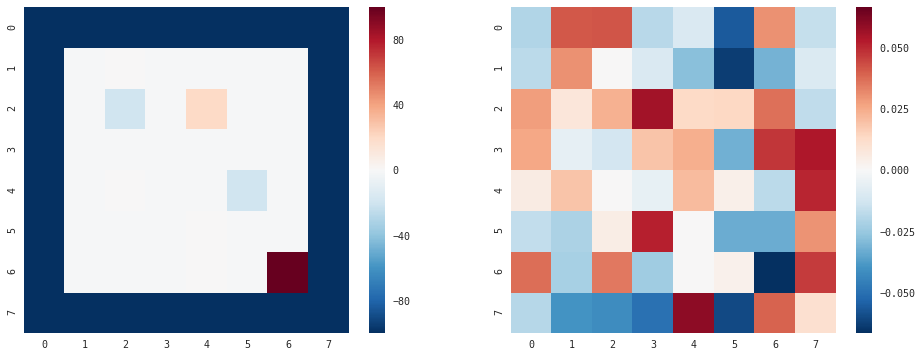

In [26]:
plot_q_values(q, reward_matrix, plot_reward=True, save_q_plot=True, t=0, episode=0)

The left hand plot is the reward grid, which looks like what we'd expect (check out the initial figure of the maze at the top of this post). And yup, the right hand plot (Q values) looks pretty random. A little bit [Mondrian](https://www.google.co.uk/search?q=mondrian+paintings&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjP2dPs4NvUAhWDPBQKHXSSAM4Q_AUICigB&biw=2100&bih=1127)?

How do we move beyond random Q values? How do we learn useful Q values that can help us navigate a maze? For that, we'll need to do some ***Q learning*** (of [DeepMind Atari fame](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)). There's actually many different varieties of Q-learning, and here we have a special simple case where there are very few, discrete states and actions (this is a tabular method), we aren't doing any feature extraction from the environment (e.g. no [deep convnets for Q learning](https://vmayoral.github.io/robots,/ai,/deep/learning,/rl,/reinforcement/learning/2016/08/07/deep-convolutional-q-learning/)), and we aren't keeping any sort of running memory (e.g. [eligibility traces](https://mpatacchiola.github.io/blog/2017/01/29/dissecting-reinforcement-learning-3.html)).

### Q function update rule

We will learn the real Q values iteratively using a simple update rule. Basically, to update $Q(s, a)$ at time $t$ (so, $Q(s_t, a_t)$), we will do a one step look ahead and find the maximum Q value you could immediately get from that successor state. In other words we peek ahead one step and find the estimate of the optimal future state. This is $\max_{a} Q(s_{t+1}, a_t)$. 

More precisely, we take our previous Q value $Q(s_t, a_t)$ for a state-action pair at time t, and make the following update:

\begin{align*}
    Q(s_t, a_t) = Q(s_t, a_t) + \alpha*\big(r_{t+1} + \gamma*  max_a Q(s_{t+1}, a_t) -  Q(s_t, a_t)\big)   
\end{align*}

The alpha parameter $\alpha$ controls your learning rate (higher values weight new information higher, which overwrites old information more). As mentioned before, the gamma parameter $\gamma$ (the 'discount factor') controls how much we prefer recent rewards to far-away rewards - if it's 0, we only ever care about immediate rewards, and if it's 1, we care about very distant rewards exactly as much as recent ones. You can change up alpha and gamma in clever ways as the algorithm trains but we'll just set them to... 0.8. :)

It's interesting to note that if you set alpha to 1.0 then the update rule becomes very short:

\begin{align*}
    Q(s_t, a_t) = r_{t+1} + \gamma*  max_a Q(s_{t+1}, a_t)    
\end{align*}

This is a recursive definition, since the current Q value depends on the immediate reward plus the discounted maximum future Q value. In this way, the $Q(s,a)$ estimates take into account the Q values of future states. The values will gradually converge after many iterations (often surprisingly few iterations), as information about future rewards eventually trickles back to the value estimates of states at the beginning of the maze. This will become clear through the code examples.

The code for doing just one Q update is:

In [28]:
def update_q_value(q, current_state, next_state, action, alpha, gamma, terminal_state, verbose=False):
    
    # make move and collect immediate reward
    reward = reward_matrix[next_state[0], next_state[1]]
    
    # the current q for the state + action we just took
    current_q = q.loc[((q['str_state']==str(current_state)) & (q['action']==action)), 'value'].values[0]
        
    # get maximum q value leading on from next_state
    max_future_q_value = np.max(q[q['str_state']==str(next_state)]['value'])
    
    # q value update rule
    new_q = current_q + alpha*(reward + gamma*max_future_q_value - current_q)
     
    # update relevant value in q table
    q.loc[((q['str_state']==str(current_state)) & (q['action']==action)), 'value'] = new_q
    
    # if next state is the terminal state, update that q value to reward
    if np.array_equal(next_state, terminal_state):
        q.loc[(q['str_state']==str(next_state)), 'value'] = 100

    if verbose:
        print 'Q of state {0} taking action "{1}" was updated from {2} to {3}'.format(current_state, action, current_q, new_q)

    return reward

Let's use this function to do a one step update. Remember this was our randomly-generated q table so far:

In [30]:
q.head(10)

,state,str_state,action,value
0,"[0, 0]","[0, 0]",down,0.027180
0,"[0, 0]","[0, 0]",right,-0.067134
1,"[0, 1]","[0, 1]",down,0.062914
1,"[0, 1]","[0, 1]",left,0.018047
1,"[0, 1]","[0, 1]",right,0.043544
2,"[0, 2]","[0, 2]",left,0.073449
2,"[0, 2]","[0, 2]",right,0.010102
3,"[0, 3]","[0, 3]",down,-0.064253
3,"[0, 3]","[0, 3]",left,-0.048198
3,"[0, 3]","[0, 3]",right,0.057700


Say we start in [0,0] and take one step to the right, to cell [0,1]. How would the `Q(s=[0,0], a='right')` be be updated from -0.067134 after this one move? This move actually puts us into a lava cell on the grid, so we hope that the negativity of this would be reflected in the updated value...

In [31]:
update_q_value(q, current_state=[0,0], next_state=[0,1], action='right', 
               alpha=0.8, gamma=0.8, terminal_state=[6,6], verbose=True)

Q of state [0, 0] taking action "right" was updated from -0.0671342301139 to -79.9731618457


-100.0

This new value really negative value replaces the previous `Q(s=[0,0], a='right')` entry in the table. 

We can double check this by hand. Recall that the reward is -100 for being in lava, `alpha` and `gamma` are both 0.8, and the previous estimate of $Q(s,a)$ was -0.0671342301139. 

The only tricky part is that we need to find the highest Q value associated with the successor state. Our starting state was [0,0] and the action we chose (maybe randomly) was 'right', so this means that the successor state is [0,1]. Looks like there are three actions we can take at state [0,1]: down, left, right. Of these, going down has the highest Q value (which is 0.062914). Plugging these values in:

In [38]:
new_q = -0.0671342301139 + 0.8*(-100 + 0.8*0.062914 - -0.0671342301139)
new_q   

-79.99603164602279

Looks good! What if we then went back left, from [0,1] to [0,0]? Q table looks like this now:

In [37]:
q.head(10)

,state,str_state,action,value
0,"[0, 0]","[0, 0]",down,0.027180
0,"[0, 0]","[0, 0]",right,-79.973162
1,"[0, 1]","[0, 1]",down,0.062914
1,"[0, 1]","[0, 1]",left,-79.978995
1,"[0, 1]","[0, 1]",right,0.043544
2,"[0, 2]","[0, 2]",left,0.073449
2,"[0, 2]","[0, 2]",right,0.010102
3,"[0, 3]","[0, 3]",down,-0.064253
3,"[0, 3]","[0, 3]",left,-0.048198
3,"[0, 3]","[0, 3]",right,0.057700


We'd expect this change (see if these values make sense to you):

In [39]:
new_q = 0.018047 + 0.8*(-100 + 0.8*0.027180 - 0.018047)
new_q   

-79.9789954

Which our function should be able to do:

In [36]:
update_q_value(q, current_state=[0,1], next_state=[0,0], action='left', 
               alpha=0.8, gamma=0.8, terminal_state=[6,6], verbose=True)

Q of state [0, 1] taking action "left" was updated from 0.0180468397972 to -79.9789951242


-100.0

Ok, so these updates are reflecting the fact that being in lava is bad. What would happen to the Q value next to the terminal state, the escape corner at [6,6]? Say we start in state [6, 5] and take a right. Let's pull out the relevant rows of Q values from the table:

In [40]:
q[q['str_state']=='[6, 5]']

,state,str_state,action,value
53,"[6, 5]","[6, 5]",down,-0.078210
53,"[6, 5]","[6, 5]",right,0.012938
53,"[6, 5]","[6, 5]",up,0.074726


In [41]:
update_q_value(q, current_state=[6,5], next_state=[6,6], action='right', 
               alpha=0.8, gamma=0.8, terminal_state=[6,6], verbose=True)

Q of state [6, 5] taking action "right" was updated from 0.0129383939485 to 80.0116636145


100.0

Success! The fact that there is a big reward at the end of taking the action 'right' from state [6,5] gets reflected in a higher `Q(s=[6,5], a='right')` value. The rewards leading on from a state get reflected in the Q values of that state.

### Learning all the Q values iteratively

The above little tidbits showed the effect of single updates in isolation, but of course we want to do many, many updates during our training episodes, until the point that the Q value estimates are stable. Once stability/convergence is reached, the hope is that the new table will accurately represent how good it is to be in any state and take any action in our environment. 

Again, the point of going through all this pain is that these techniques are super general - if you have an environment where you can make actions that are associated with reward, some variant of Q learning is probably applicable. 

Just one more thing to think about before we run the training. It's actually possible to learn good Q values by randomly walking around the maze (taking actions completely at random) and just observing which rewards come your way. Even though we'd be building better and better estimates of how to optimally behave, we aren't following that advice, and instead are using a totally different, random policy to move around the world. But another approach is to take actions that you think are good, at the same time as you're building your estimates of how good they are. This would mean that your actions would be influenced by the Q values you learn in real time as you learn about them.

So basically, we can learn about the optimal policy while being maximally exploratory. Alternatively, as we gather information, we can let this immediately change how we behave. 

The parameter epsilon ($\epsilon$) controls to what extent our decisions about actions will be random. Do we *always* want to make random decisions about movement (set $\epsilon$>1), or only *sometimes* make random decisions (0<$\epsilon$<1), or *always* go where the utility values look best ($\epsilon$=0)? Let's try setting `epsilon=0.5`, which will lead to random movements 50% of the time, but 50% of the time we choose the best-looking action (to the best of our knowledge at that point).

The function to run the entire simulation is this (explanation below):

In [45]:
def learn_maze(reward_matrix, lava_grid=True, alpha=0.8, gamma=0.8, epsilon=0.5, 
               n_episodes=15, t_per_episode=1000, verbose=False, 
               plot_often=False, plot_episode_end=True):

    # initialise q table
    q = initialise_q_table(reward_matrix, use_zero=False)

    # episodes end when terminal state reached (escaped==True)
    for episode in range(int(n_episodes)):

        print 'Commencing episode number {0}...'.format(episode)
        t = 0
        escaped = False
        total_reward = 0
        
        # arbitrarily begin in the top left non-lava corner of the grid
        if lava_grid:
            current_state = [1,1]
            terminal_state = [6,6]  
        # if using simple maze
        else:
            current_state = [0,0]
            terminal_state = [5,5]

        # while you're in the maze, make decisions about actions
        while not escaped and t < t_per_episode:
            
            # get q table info relating to your current state
            current_state_slice = q[q['str_state'] == str(current_state)]

            # small chance of acting randomly (epsilon)
            if np.random.rand() < epsilon:
                valid_moves = np.array(current_state_slice['action'])
                action = np.random.choice(valid_moves)

            # otherwise, do what looks best
            else:
                'Taking best action'
                best_action_index = np.argmax(np.array(current_state_slice['value']))
                action = np.array(current_state_slice['action'])[best_action_index]           

            next_state = move(current_state, action)

            # get your reward and update your q value
            total_reward += update_q_value(q, current_state, next_state, action, alpha=alpha, gamma=gamma,
                                           terminal_state=terminal_state, verbose=verbose)

            # if you reached the terminal state, you win gg
            if np.array_equal(next_state, terminal_state):
                print 'Escaped maze in {0} time steps with {1} total reward.'.format(t, total_reward)
                escaped = True
                
                if plot_episode_end:
                    plot_q_values(q, reward_matrix, save_q_plot=True, t=t, episode=episode)

            # update current state and time step
            # occasionally plot q values
            if plot_often:
                if t == 0 or t % 500 == 0:
                    print 'Current state at time {0} is: {1}'.format(t, current_state)
                    plot_q_values(q, reward_matrix, save_q_plot=True, t=t, episode=episode)

            t += 1
            current_state = next_state
            
    return q

This function is a bit dense-looking but is actually composed of very simple things:

+ **Line 6**: Initialise the Q values randomly (or to all zeros)
+ **Line 9**: We'll let the worm do many different runs through the maze
+ **Lines 16-21**: Depending on whether you want to run the basic maze or the advanced maze with the lava moat, the starting position and the position (the terminal state) will vary. 
+ **Line 24**: Given that you haven't escaped (reached the terminal state), and your time hasn't run out (arbitrary n), make decisions about where to go next in the grid.
+ **Line 27**: Just taking a slice of the Q table that relates to our current state, for convenience, since we'll be using these values below.
+ **Lines 30 to 32**: Sample a random value between 0 and 1 using np.random.rand(). If this is less than epsilon, choose a random action out of the available ones
+ **Lines 35 to 38**: If the random value wasn't less than epsilon, choose the action associated with the highest utility. 
+ **Line 40**: whichever action you chose, now's the time to get the next state it leads to.
+ **Line 43**: Update your Q value by looking ahead one step from this `next_state` (see previous sections for explanation). 
+ **Lines 47 to 52**: Check if this next state is actually the terminal state. If it is, you reached the end of the maze! Make a self-congratulatory plot of the q table as it stands (if `plot_episode_end==True`) and set `escaped` to `True`.
+ **Lines 56 to 59**: A bit of monitoring code - if you'd like to keep a closer tab on the Q values as they evolve, pass `plot_often=True`. 
+ **Lines 61 and 62**: Incrementing the time step and updating our current state.

Let's run one episode.

Commencing episode number 0...
Escaped maze in 3093 time steps with -11142.0 total reward.


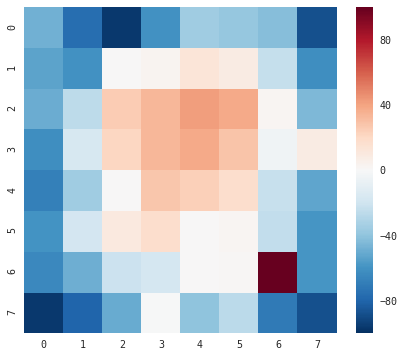

In [59]:
q = learn_maze(reward_matrix, lava_grid=True, alpha=0.8, gamma=0.8, epsilon=0.5, 
               n_episodes=1, t_per_episode=10000, verbose=False, plot_often=False, plot_episode_end=True)

Let's see that reward grid again?

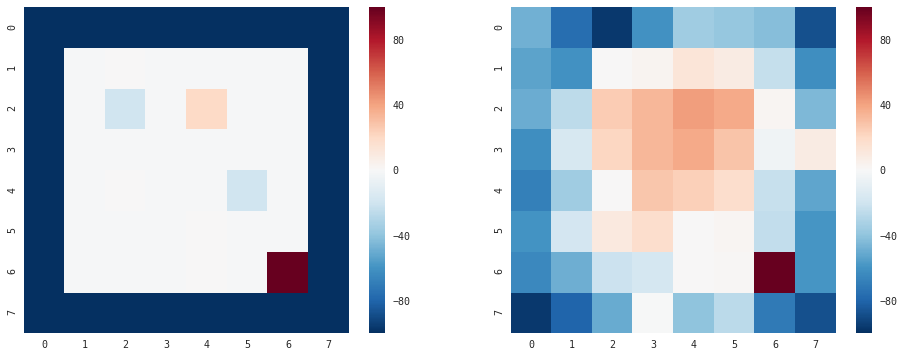

In [60]:
plot_q_values(q, reward_matrix, plot_reward=True, save_q_plot=True, t=0, episode=0)

Cool, definitely looks inspired by the reward grid, even after just 1 short episode. Given that we were plonked into this world with absolutely zero knowledge about the world (we could only try things out and get feedback from the environment), we now already know quite a bit. 

Since the heatmap shows averaged Q values per state (i.e. averaged over available actions for each state, for visualisation purposes), it's hard to see some detail. Say in position [2,3], which is in between a -20 and +20 bonus, what are the Q values like?

In [61]:
q[q['str_state']=='[2, 3]']

,state,str_state,action,value
19,"[2, 3]","[2, 3]",up,32.333333
19,"[2, 3]","[2, 3]",down,32.333333
19,"[2, 3]","[2, 3]",left,13.333333
19,"[2, 3]","[2, 3]",right,53.333333


Ok whew, it's learned that going right is best and going left is worst. As we would expect.

What about position [6,5], just one step away from the ultimate goal?

In [62]:
q[q['str_state']=='[6, 5]']

,state,str_state,action,value
53,"[6, 5]","[6, 5]",down,-80.025761
53,"[6, 5]","[6, 5]",right,80.013743
53,"[6, 5]","[6, 5]",up,2.790338


Great, going right is loads better than the other options.

Go ahead and see how changing the number of episodes, episode length, and other parameters changes what you learn. For instance, below we are learning over 10 episodes, and we can see that we seem to be escaping the maze in a shorter amount of time and getting more reward. 

In [66]:
q2 = learn_maze(reward_matrix, lava_grid=True, alpha=0.8, gamma=0.8, epsilon=0.5, 
               n_episodes=10, t_per_episode=10000, verbose=False, plot_often=False, plot_episode_end=False)

Commencing episode number 0...
Escaped maze in 959 time steps with -6105.0 total reward.
Commencing episode number 1...
Escaped maze in 395 time steps with -2831.0 total reward.
Commencing episode number 2...
Escaped maze in 1221 time steps with -5180.0 total reward.
Commencing episode number 3...
Escaped maze in 311 time steps with -1358.0 total reward.
Commencing episode number 4...
Escaped maze in 347 time steps with -1860.0 total reward.
Commencing episode number 5...
Escaped maze in 61 time steps with -1581.0 total reward.
Commencing episode number 6...
Escaped maze in 427 time steps with -2682.0 total reward.
Commencing episode number 7...
Escaped maze in 101 time steps with -184.0 total reward.
Commencing episode number 8...
Escaped maze in 19 time steps with -75.0 total reward.
Commencing episode number 9...
Escaped maze in 31 time steps with -163.0 total reward.


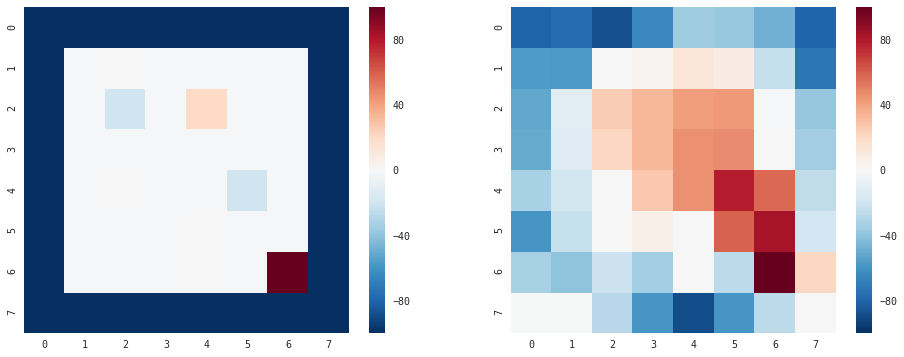

In [67]:
plot_q_values(q2, reward_matrix, plot_reward=True, save_q_plot=True, t=0, episode=0)

With 10 episodes, it looks like the agent has learned enough about the environment to have a go at traversing it efficiently. 

### Using Q values to quickly leave the maze

Now that we've gathered lots of information about the Q values (though normally we'd train for much, much longer), traversing the maze again is ez mode. For each state we're in, we are just going to greedily choose the available action with the highest utility, and keep doing that until we escape. 

The code for traversing the grid is simple (extremely simlar to `learn_maze` code above) but plotting is a bit of a pain. We will need two helper functions to make nice GIFs to visualise our path in the maze. The `plot_current_position` function takes your current position and plots it on the learned Q values heatmap. The `make_traversal_gif` function uses [imageio](https://imageio.readthedocs.io/en/latest/) magic to spit out a gif (make sure the `image_path` directory only has .png files that you want included in your GIF... clean out those cat memes). 

In [220]:
not np.array_equal(next_state, terminal_state)

False

In [77]:
import matplotlib.patches as patches
import glob
import imageio
from natsort import natsorted

In [178]:
def traverse_grid(q, lava_grid=True, plot_each_step=True):
    
    print 'Traversing maze...'
    
    if lava_grid:
        current_state = [1, 1]
        terminal_state = [6, 6]
    else:
        current_state = [0, 0]
        terminal_state = [5, 5]
    
    t=0
    
    # traverse greedily
    while not np.array_equal(next_state, terminal_state):

        print 'Current state is: {0}'.format(current_state)
        
        if plot_each_step:
            plot_current_position(current_state, t, q)

        # lookup q values of actions in current states
        current_state_slice = q[q['str_state'] == str(current_state)]
        best_action_index = np.argmax(np.array(current_state_slice['value']))
        action = np.array(current_state_slice['action'])[best_action_index] 
        
        # make a move
        next_state = move(current_state, action)

        # if you won then plot it
        if next_state == terminal_state and plot_each_step==True:
            plot_current_position(next_state, t+1, q, reached_terminal=True)
            
        current_state = next_state
        t += 1
    
    # when done, make gif of path taken
    make_traversal_gif(t)

In [179]:
def plot_current_position(current_state, t, q, reward_matrix=reward_matrix, reached_terminal=False):
    
    # plot heatmap of q values
    nrows, ncols = reward_matrix.shape
    avg_q_value_by_state = q.groupby('str_state')['value'].mean().values.reshape(nrows,ncols)
    plt.figure(figsize=(7,6))
    heatmap = sns.heatmap(avg_q_value_by_state)        
    
    # add rectangle for current position
    if not reached_terminal:
        heatmap.add_patch(patches.Rectangle((current_state[1], 7-current_state[0]), 1, 1, 
                                       fill=True, alpha=0.25, linewidth=1))
        heatmap.add_patch(patches.Rectangle((current_state[1], 7-current_state[0]), 1, 1, 
                                       fill=False, color='black', linewidth=5))
    else: 
        heatmap.add_patch(patches.Rectangle((current_state[1], 7-current_state[0]), 1, 1, 
                                       fill=True, alpha=0.25, linewidth=1))
        heatmap.add_patch(patches.Rectangle((current_state[1], 7-current_state[0]), 1, 1, 
                                       fill=False, color='white', linewidth=8))
        
    # save fig
    heatmap.get_figure().savefig('png_for_gif/' + 'traversing_step_' + str(t) + '.png')

In [180]:
def make_traversal_gif(t, image_path='png_for_gif/*.png', gif_path='png_for_gif/'):
    
    # grab images to GIFify
    images = natsorted(glob.glob(image_path))
    gif_name = gif_path + 'traversal_in_' + str(t) + '_steps_random.gif'

    with imageio.get_writer(gif_name, mode='I',  duration=0.5) as writer:
        for image_name in images:
            image = imageio.imread(image_name)
            writer.append_data(image)

Now we can run this:

In [ ]:
traverse_grid(q2, lava_grid=True, plot_each_step=True)

And get this GIF of our path across the maze out as a result:

![Traversal](https://raw.githubusercontent.com/jagex-data-science/maze_runner/master/traversal_in_10_steps_random_p0.0.gif)

This is ok but we can probably do better. 

In [97]:
q3 = learn_maze(reward_matrix, lava_grid=True, alpha=0.8, gamma=0.8, epsilon=0.5, 
               n_episodes=100, t_per_episode=10000, verbose=False, plot_often=False, plot_episode_end=False)

Commencing episode number 0...
Escaped maze in 5721 time steps with -18901.0 total reward.
Commencing episode number 1...
Escaped maze in 69 time steps with -1021.0 total reward.
Commencing episode number 2...
Escaped maze in 1811 time steps with -6425.0 total reward.
Commencing episode number 3...
Escaped maze in 653 time steps with -344.0 total reward.
Commencing episode number 4...
Escaped maze in 397 time steps with -2921.0 total reward.
Commencing episode number 5...
Escaped maze in 337 time steps with -1730.0 total reward.
Commencing episode number 6...
Escaped maze in 425 time steps with -53.0 total reward.
Commencing episode number 7...
Escaped maze in 85 time steps with 83.0 total reward.
Commencing episode number 8...
Escaped maze in 57 time steps with -914.0 total reward.
Commencing episode number 9...
Escaped maze in 51 time steps with -272.0 total reward.
Commencing episode number 10...
Escaped maze in 53 time steps with -916.0 total reward.
Commencing episode number 11...

Traversing maze...
Current state is: [1, 1]
Current state is: [2, 1]
Current state is: [3, 1]
Current state is: [3, 2]
Current state is: [3, 3]
Current state is: [3, 4]
Current state is: [3, 5]
Current state is: [4, 5]
Current state is: [5, 5]
Current state is: [5, 6]


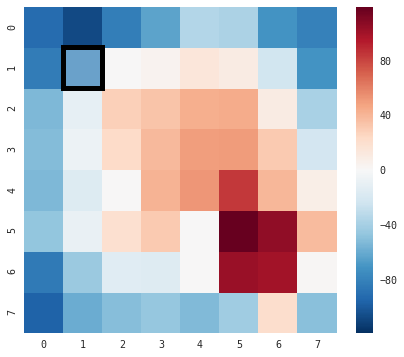

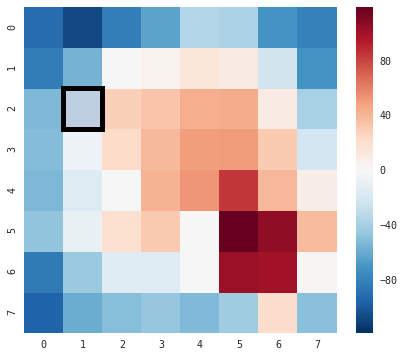

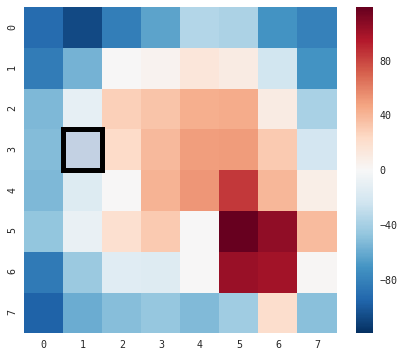

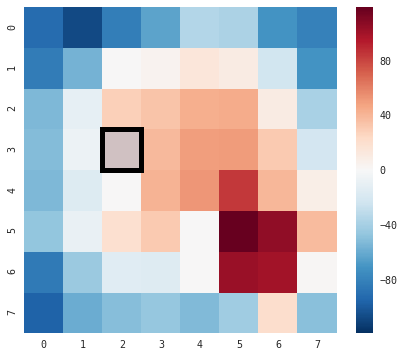

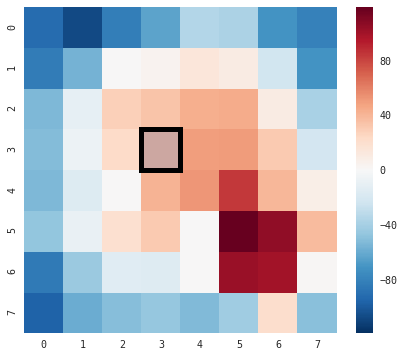

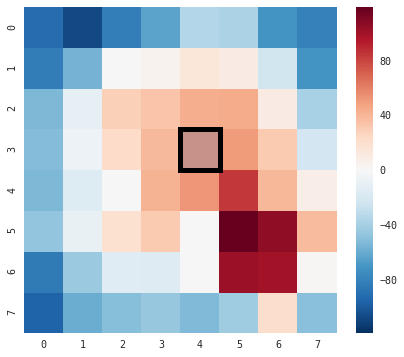

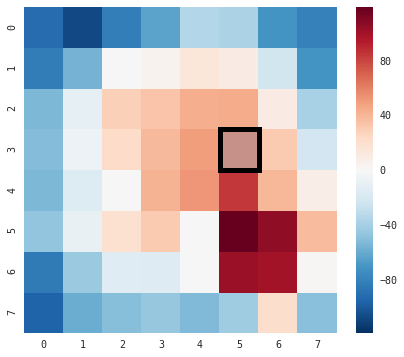

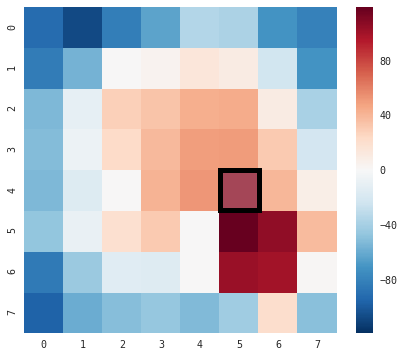

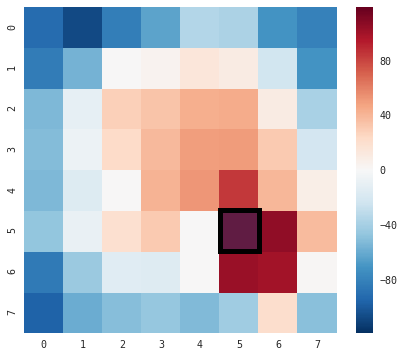

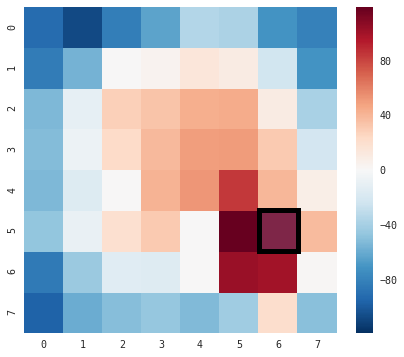

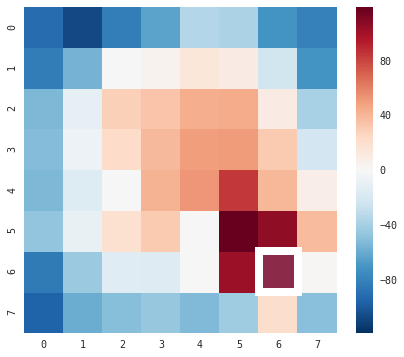

In [181]:
traverse_grid(q3, lava_grid=True, plot_each_step=True)

Much better. But it's not really picking up on the minor rewards as well as you'd think... maybe the agent needs a bit of a push to do more random exploration? More episodes? Maybe it'll do a better job with [SARSA updates rather than Q learning updates](https://mpatacchiola.github.io/blog/2017/01/29/dissecting-reinforcement-learning-3.html)? See if you can get an improved result. 

## Summary

So, in short, using a very basic version of Q learning, we have a general method for getting solutions to grid worlds. 

Some ideas of experiments you might want to try (that might also be covered in the next blog post):
    1. Effects of increasing number of learning episodes; observing and measuring convergence
    2. Cutting episodes short by restricting max t
    3. Changing keeness to update previous knowledge (gamma)
    4. Changing the learning rate (alpha)
    5. Changing the update rule to SARSA
    6. Changing probability of random actions (epsilon)
    7. Normalisation of Q values by state (e.g. to be between 0 and 1)
    8. Playing around with different maze configurations

It'd also be nice to have better Q value visualisations - instead of values being averaged in all directions to get one value per state, it would be better to represent action-specific utility values with little arrows with variable thickness (like in [Richard Sutton's grid world demo at 41:00](https://youtu.be/ggqnxyjaKe4?t=2463)). But.. this seemed like a pain to do in matlab. 

If you found this post particularly interesting or find some mistakes (confession: am noob), let me know :) 